# Trabajo practico Nº2
### Mineria de datos - TUIA
### 08/11/2024
#### Integrantes:
Bravi Eugenio B-6600/1

Nemeth Ulises N-1249/1

# Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score,recall_score, precision_score,f1_score,confusion_matrix
from sklearn.model_selection import GridSearchCV

# Carga de datos

In [67]:
df_companies = pd.read_csv('./1000_Companies.csv')
df_companies.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [68]:
df_pokemon = pd.read_csv('./PokemonDBCart.csv')
df_pokemon.head()

,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
0,Bulbasaur,49,49,45,45,65,65,hierba
1,Ivysaur,62,63,60,60,80,80,hierba
2,Venusaur,100,123,80,80,122,120,hierba
3,Charmander,52,43,65,39,60,50,fuego
4,Charmeleon,64,58,80,58,80,65,fuego


# 1. Analisis de datos dataset companies

In [69]:
df_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [70]:
df_companies.isna().sum()

RyD_Spend         0
Administration    0
MarketingSpend    0
State             0
Profit            0
dtype: int64

In [71]:
X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(df_companies.drop('Profit', axis=1), df_companies['Profit'], test_size=0.2, random_state=42)

In [72]:
X_train_comp.describe()

,RyD_Spend,Administration,MarketingSpend
count,800.000000,800.000000,800.000000
mean,81975.291150,122887.896835,226969.821069
std,46707.482003,11574.679339,92039.930034
min,0.000000,51283.140000,0.000000
25%,43084.500000,116654.899500,150969.584600
50%,81054.500000,122746.690400,228190.695800
75%,123806.750000,129060.069850,307664.501425
max,165349.200000,270939.860000,471784.100000


array([[<Axes: title={'center': 'RyD_Spend'}>,
        <Axes: title={'center': 'Administration'}>],
       [<Axes: title={'center': 'MarketingSpend'}>, <Axes: >]],
      dtype=object)

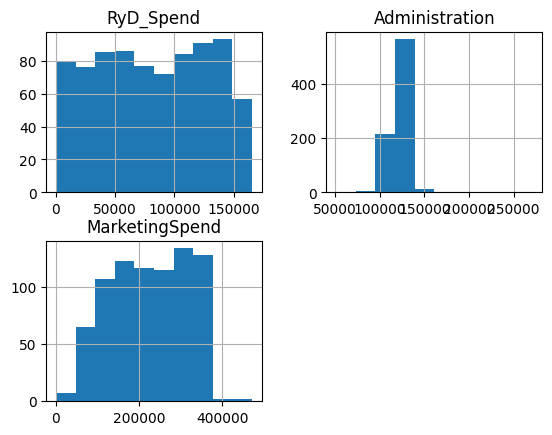

In [73]:
X_train_comp.hist()

Se observa que el dataset presenta distintas escalas por lo que sera necesario aplicarle un escalado a los datos para evitar problemas en la creacion del arbol de decisiones.

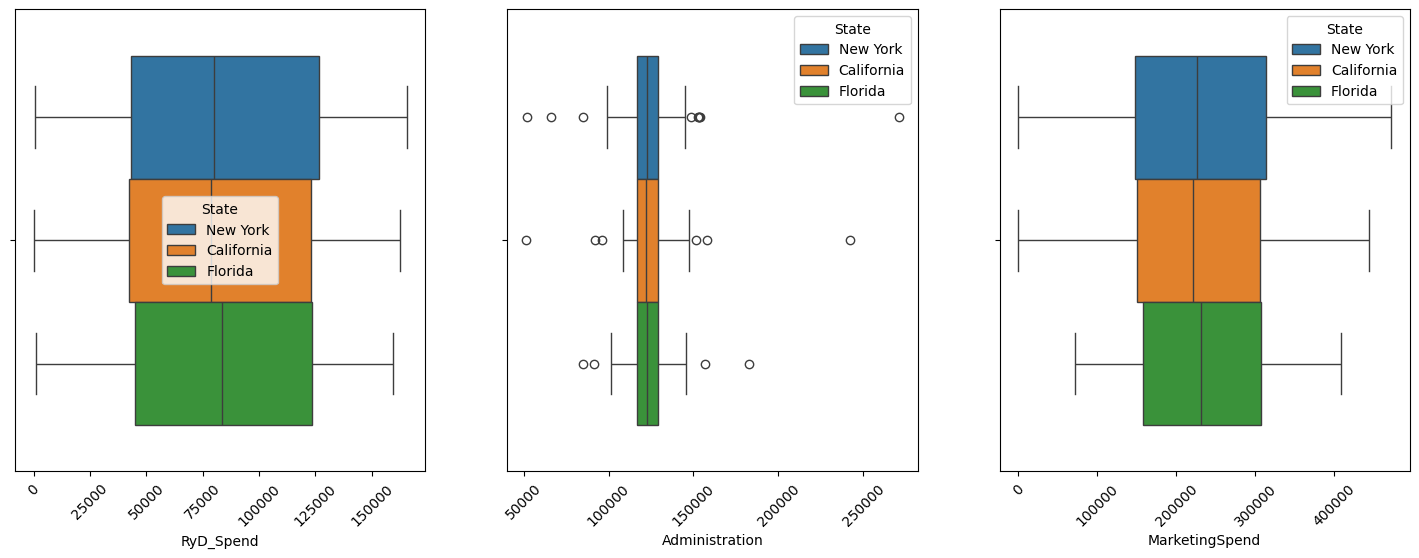

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='RyD_Spend', data=X_train_comp, orient='h', ax=axes[0], hue='State')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='Administration', data=X_train_comp, orient='h', ax=axes[1], hue='State')
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(x='MarketingSpend', data=X_train_comp, orient='h', ax=axes[2], hue='State')
axes[2].tick_params(axis='x', rotation=45)

plt.show()

In [75]:
# Analisis de balanceo de datos
state_counts = X_train_comp['State'].value_counts()

# Obtener el valor máximo y mínimo
max_value = state_counts.max()
min_value = state_counts.min()

percentage_difference = ((max_value - min_value) / max_value) * 100

# Mostrar el resultado
print(f'{state_counts}\nLa diferencia porcentual entre el valor máximo y mínimo es: {percentage_difference:.2f}%')

State
New York      279
California    267
Florida       254
Name: count, dtype: int64
La diferencia porcentual entre el valor máximo y mínimo es: 8.96%


Se observa que los datos estan razonablemente balanceados ya que hay una diferencia menor al 10% en la cantidad de datos en cada clase.
Tambien se observa que que la variable 'Administration' cuenta con valores atipicos por lo que se tendra que utilizar RobustScaler como el scaler a utilizar.

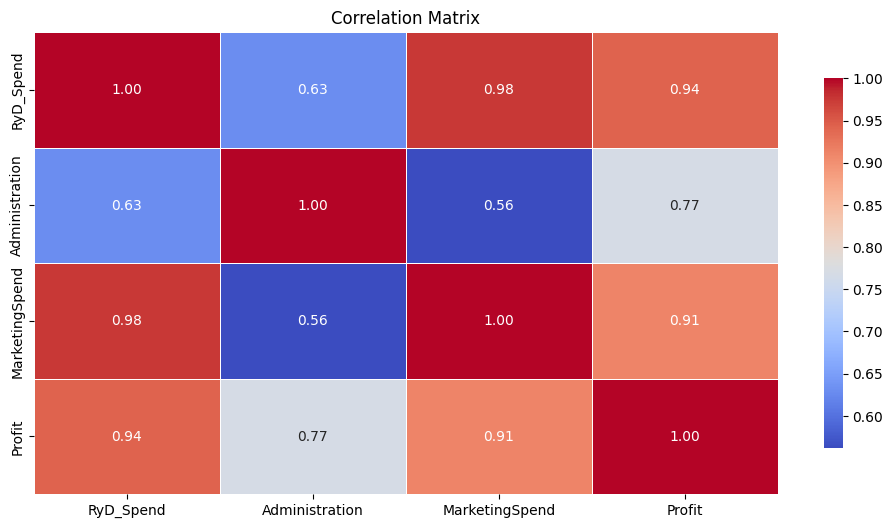

In [76]:
df_train_comp = pd.concat([X_train_comp, y_train_comp], axis=1)
correlation_matrix = df_train_comp[['RyD_Spend','Administration','MarketingSpend','Profit']].corr()
# Crear el heatmap con seaborn
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix,  annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix")
plt.show()

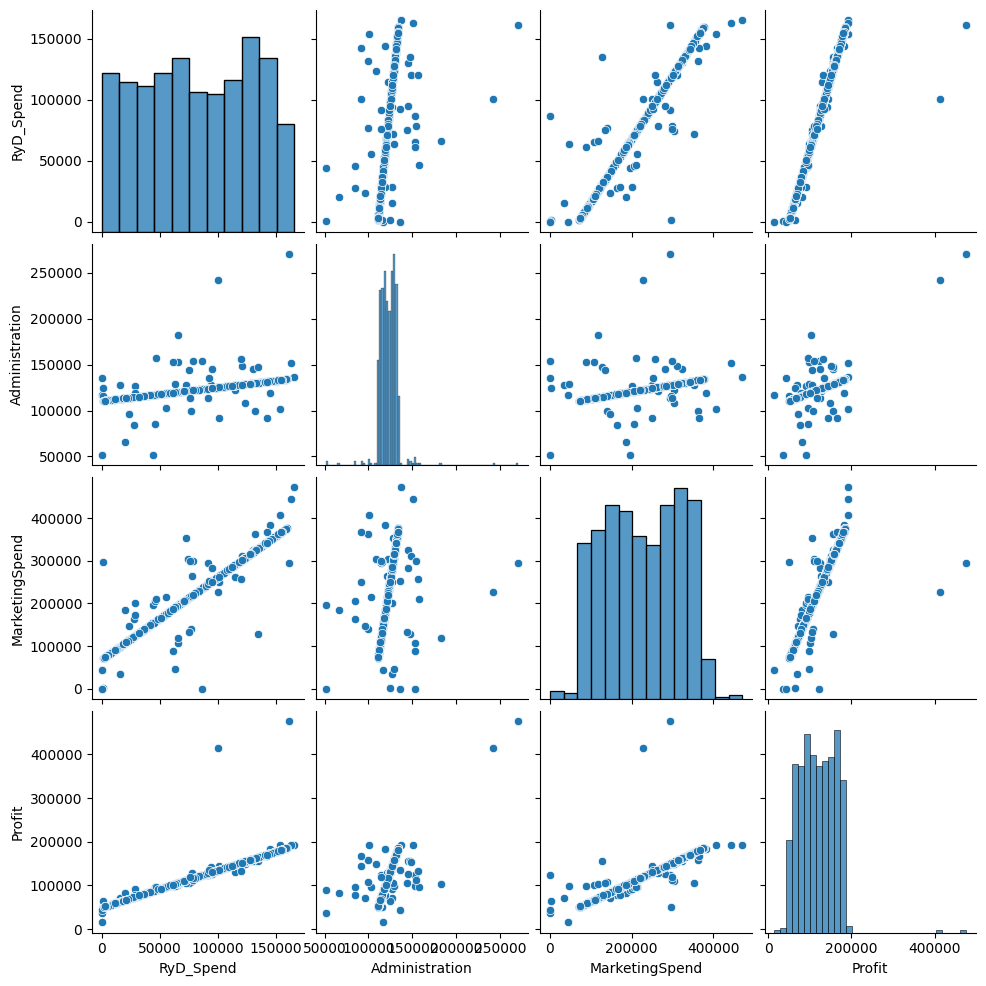

In [77]:
#Pairplot
for i in range(0, len(df_train_comp[['RyD_Spend','Administration','MarketingSpend','Profit']].columns), 5):
    sns.pairplot(data=df_train_comp[['RyD_Spend','Administration','MarketingSpend','Profit']],
                x_vars=df_train_comp[['RyD_Spend','Administration','MarketingSpend','Profit']].columns[i:i+5],
                y_vars=['RyD_Spend','Administration','MarketingSpend','Profit'],
)  
    plt.show()

Se observa que hay fuertes correlaciones entre las variables sobre todo entre las variables 'RyD_Spend','MarketingSpend','Profit' que tienen una correlación en el rango de (0.91-0.98) siendo una correlacion casi lineal. 

In [78]:
X_train_comp = pd.get_dummies(X_train_comp, columns=['State'], drop_first=True)
X_test_comp = pd.get_dummies(X_test_comp, columns=['State'], drop_first=True)
X_train_comp.head()

,RyD_Spend,Administration,MarketingSpend,State_Florida,State_New York
29,65605.48,153032.0600,107138.38000,False,True
535,12068.00,112239.3528,92064.27813,False,False
695,133587.00,130185.8323,326535.52050,False,False
557,83794.00,122832.1752,230459.79100,False,False
836,141217.00,131312.6654,341257.62630,False,True


In [79]:
robust_scaler = RobustScaler().set_output(transform='pandas')
X_train_comp_esc = robust_scaler.fit_transform(X_train_comp)
X_test_comp_esc = robust_scaler.transform(X_test_comp)

# 2. Árboles de decisión (Regresión)

In [80]:
arbol_regresion = tree.DecisionTreeRegressor(max_depth=3, min_samples_leaf=3, min_samples_split=3, random_state=42)
arbol_regresion.fit(X_train_comp_esc,y_train_comp)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=3, min_samples_split=3,
                      random_state=42)

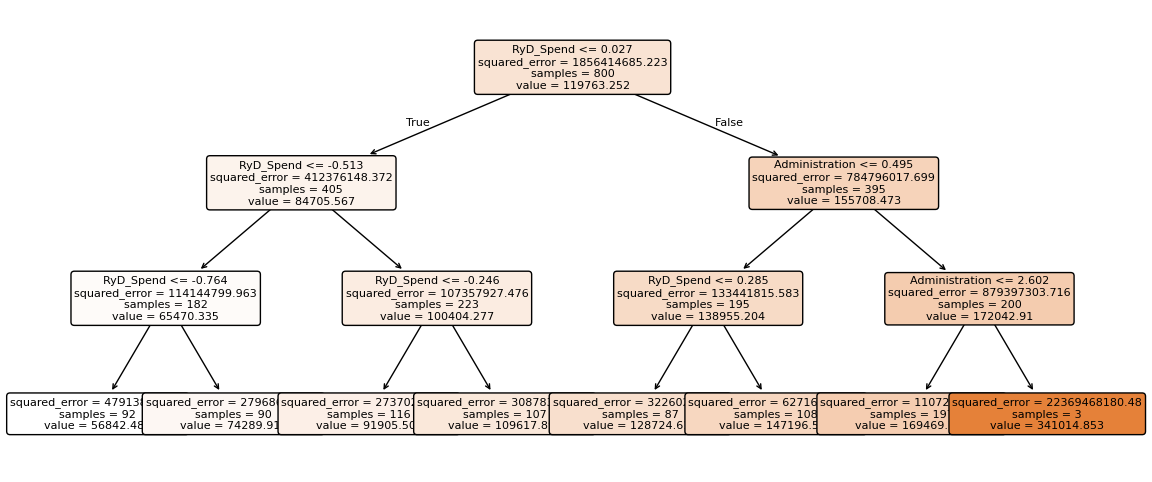

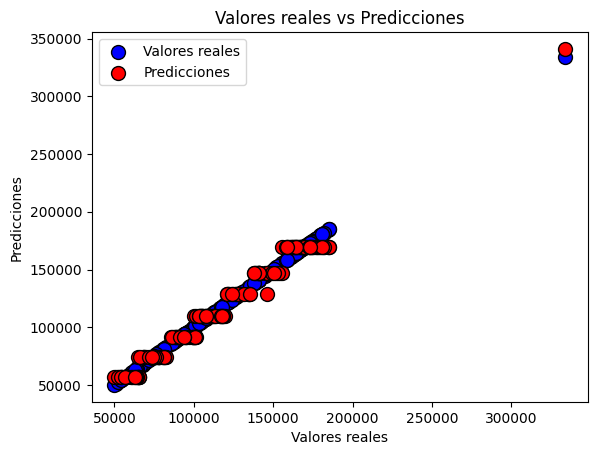

Mean Absolute Error (MAE): 5151.689635062966
Mean Squared Error (MSE): 38425634.06183691
Root Mean Squared Error (RMSE): 6198.841348335744


In [81]:
y_pred = arbol_regresion.predict(X_test_comp_esc)
features = list(X_test_comp_esc.columns)
plt.figure(figsize=(14,6))
tree.plot_tree(arbol_regresion, feature_names=features, fontsize=8, filled=True, rounded=True)
plt.show()
# Crear el scatter plot con diferentes colores para cada conjunto
plt.scatter(y_test_comp, y_test_comp, color='blue', label='Valores reales', s=100, edgecolor='k')
plt.scatter(y_test_comp, y_pred, color='red', label='Predicciones', s=100, edgecolor='k')

# Etiquetas y título
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.legend()
plt.show()

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test_comp, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test_comp, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test_comp, y_pred)))

Se observa un gran error medio en todas las metricas, esto se debe a que el modelo no tiene los hiperparametros optimizados y esta underfitting. Tambien se observa que el MAE es la mejor metrica para evaluar el rendimiento ya que esta mestrica es la que menos se ve afectada por los outliers.

In [82]:
#Optimizamos los hiperparametros
param_grid = {
    'max_depth': list(range(3,15)),
    'min_samples_leaf': list(range(1,5)),
    'min_samples_split': list(range(2,10))
}

# Crear el GridSearchCV
grid_search = GridSearchCV(estimator=tree.DecisionTreeRegressor(random_state=42), param_grid=param_grid,cv=4, scoring='neg_mean_absolute_error')

# Ajustar el modelo
grid_search.fit(X_train_comp_esc, y_train_comp)

# Mostrar los mejores hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2}


c:\Users\Usuario\OneDrive\Escritorio\Facultad\data mining\TP2\TP2_mineria\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [83]:
arbol_regresion_ajustado = tree.DecisionTreeRegressor(max_depth=11, min_samples_leaf=1, min_samples_split=2, random_state=42)
arbol_regresion_ajustado.fit(X_train_comp_esc,y_train_comp)

DecisionTreeRegressor(max_depth=11, random_state=42)

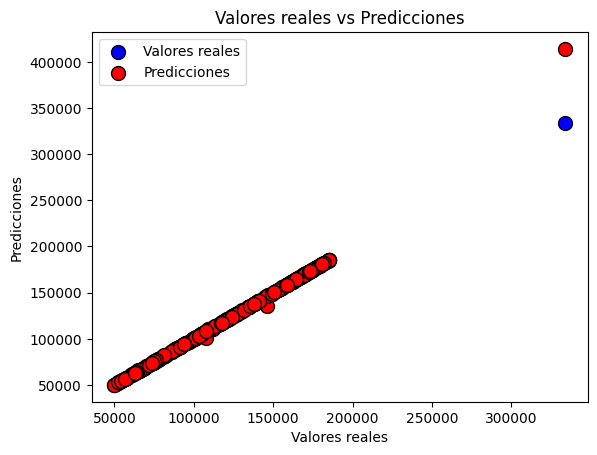

Mean Absolute Error (MAE): 634.3757938499994
Mean Squared Error (MSE): 32812387.718446888
Root Mean Squared Error (RMSE): 5728.209817948963


In [84]:
y_pred = arbol_regresion_ajustado.predict(X_test_comp_esc)
# Crear el scatter plot con diferentes colores para cada conjunto
plt.scatter(y_test_comp, y_test_comp, color='blue', label='Valores reales', s=100, edgecolor='k')
plt.scatter(y_test_comp, y_pred, color='red', label='Predicciones', s=100, edgecolor='k')

# Etiquetas y título
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.legend()
plt.show()

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test_comp, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test_comp, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test_comp, y_pred)))

Se observa que el arbol con los hiperparametros ajustados con GridSearchCV tiene un rendimiento muy superior al modelo sin ajustar, ademas se puede observar que la prediccion del profit tiende a ser una regeresion lineal.

# 3. Analisis de datos dataset pokemon

In [85]:
#Sacamos la variable nombres ya que no va a ser utilizada
df_pokemon = df_pokemon.drop(['Nombre'], axis=1)


In [86]:
df_pokemon.isna().sum()

Ataque         0
Defensa        0
Velocidad      0
HP             0
SpAtaque       0
SpDefensa      0
TipoPokemon    0
dtype: int64

In [87]:
X_train_poke_1, X_test_poke_1, y_train_poke_1, y_test_poke_1 = train_test_split(df_pokemon.drop('TipoPokemon', axis=1), df_pokemon['TipoPokemon'], test_size=0.2, random_state=42)
X_train_poke_2, X_test_poke_2, y_train_poke_2, y_test_poke_2 = train_test_split(df_pokemon.drop('TipoPokemon', axis=1), df_pokemon['TipoPokemon'], test_size=0.3, random_state=42)

In [88]:
X_train_poke_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, 117 to 102
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Ataque     383 non-null    int64
 1   Defensa    383 non-null    int64
 2   Velocidad  383 non-null    int64
 3   HP         383 non-null    int64
 4   SpAtaque   383 non-null    int64
 5   SpDefensa  383 non-null    int64
dtypes: int64(6)
memory usage: 20.9 KB


In [89]:
X_train_poke_1.describe()

,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,74.428198,70.699739,66.845953,66.671018,73.227154,70.498695
std,31.140106,28.487734,29.998687,24.847627,31.791172,26.039929
min,5.000000,5.000000,5.000000,1.000000,15.000000,20.000000
25%,50.000000,50.000000,45.000000,50.000000,50.000000,50.000000
50%,70.000000,65.000000,65.000000,65.000000,69.000000,67.000000
75%,95.000000,88.000000,87.500000,77.500000,95.000000,87.500000
max,185.000000,200.000000,180.000000,255.000000,194.000000,154.000000


array([[<Axes: title={'center': 'Ataque'}>,
        <Axes: title={'center': 'Defensa'}>],
       [<Axes: title={'center': 'Velocidad'}>,
        <Axes: title={'center': 'HP'}>],
       [<Axes: title={'center': 'SpAtaque'}>,
        <Axes: title={'center': 'SpDefensa'}>]], dtype=object)

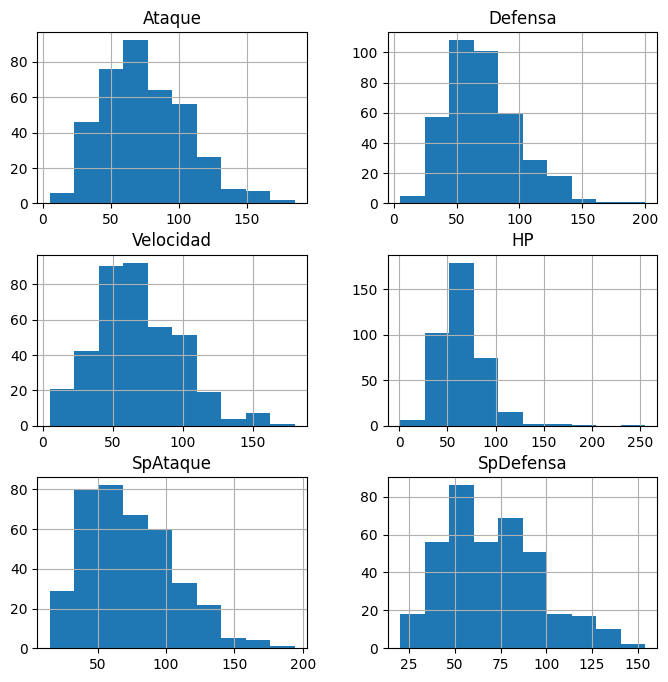

In [90]:
X_train_poke_1.hist(figsize=(8,8))

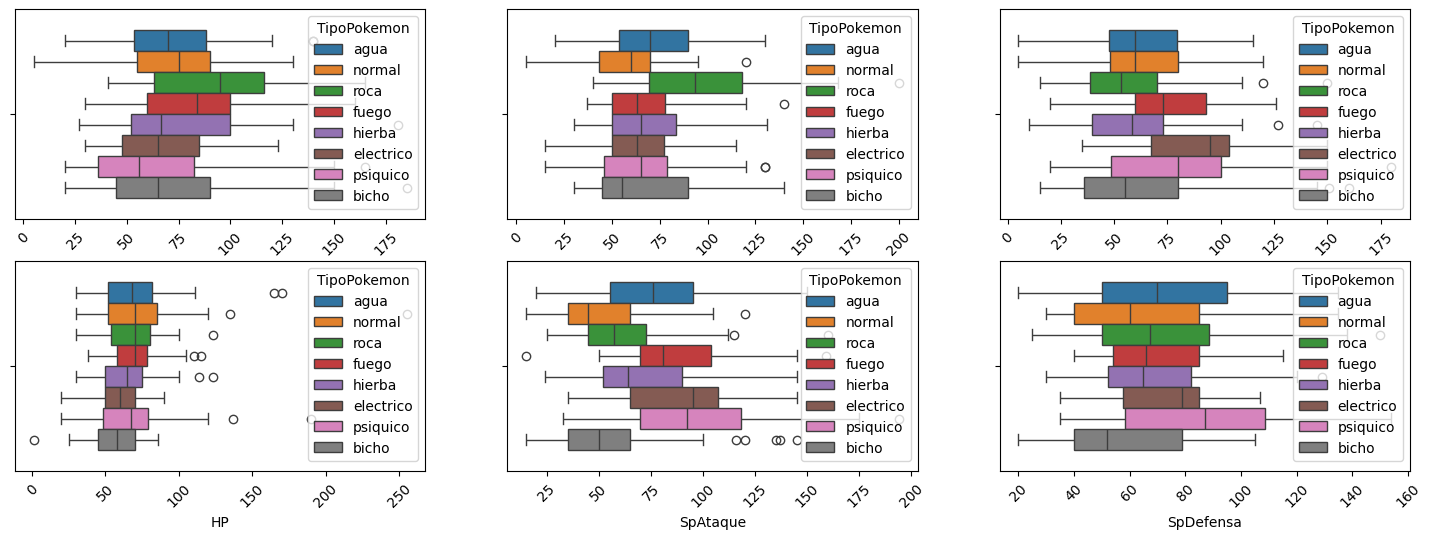

In [91]:
fig, axes = plt.subplots(2, 3, figsize=(18, 6))

sns.boxplot(x='Ataque', data=X_train_poke_1, orient='h', ax=axes[0,0], hue=y_train_poke_1)
axes[0,0].tick_params(axis='x', rotation=45)

sns.boxplot(x='Defensa', data=X_train_poke_1, orient='h', ax=axes[0,1], hue=y_train_poke_1)
axes[0,1].tick_params(axis='x', rotation=45)

sns.boxplot(x='Velocidad', data=X_train_poke_1, orient='h', ax=axes[0,2], hue=y_train_poke_1)
axes[0,2].tick_params(axis='x', rotation=45)

sns.boxplot(x='HP', data=X_train_poke_1, orient='h', ax=axes[1,0], hue=y_train_poke_1)
axes[1,0].tick_params(axis='x', rotation=45)

sns.boxplot(x='SpAtaque', data=X_train_poke_1, orient='h', ax=axes[1,1], hue=y_train_poke_1)
axes[1,1].tick_params(axis='x', rotation=45)

sns.boxplot(x='SpDefensa', data=X_train_poke_1, orient='h', ax=axes[1,2], hue=y_train_poke_1)
axes[1,2].tick_params(axis='x', rotation=45)

plt.show()

Se observa que el dataset posee algunos outliers por lo que sera conveniente usar RobustScaler

In [92]:
# Analisis de balanceo de datos
poke_counts = y_train_poke_1.value_counts()

# Obtener el valor máximo y mínimo
max_value = poke_counts.max()
min_value = poke_counts.min()

percentage_difference = ((max_value - min_value) / max_value) * 100

# Mostrar el resultado
print(f'{poke_counts}\nLa diferencia porcentual entre el valor máximo y mínimo es: {percentage_difference:.2f}%')

TipoPokemon
hierba       64
agua         63
bicho        53
normal       45
fuego        45
psiquico     42
roca         40
electrico    31
Name: count, dtype: int64
La diferencia porcentual entre el valor máximo y mínimo es: 51.56%


Se observa desbalance importante de clases por lo que sera necesario utilizar tecnicas de balanceo de clases.

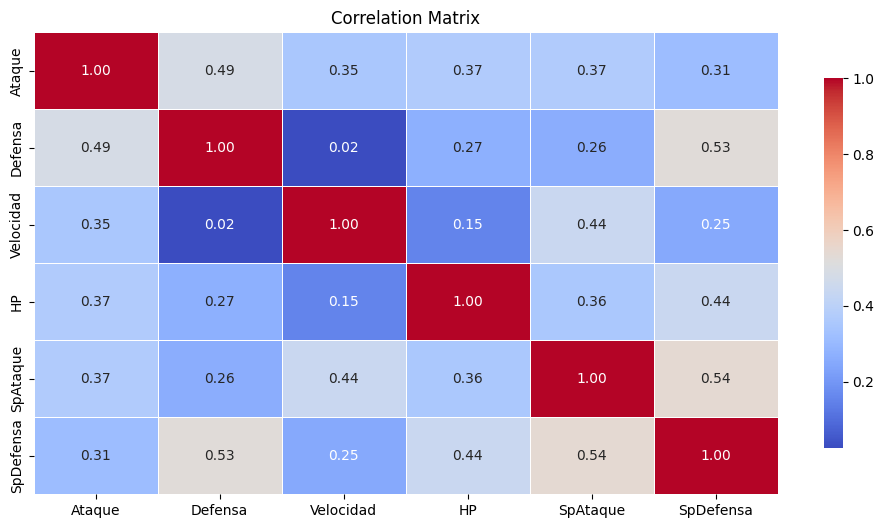

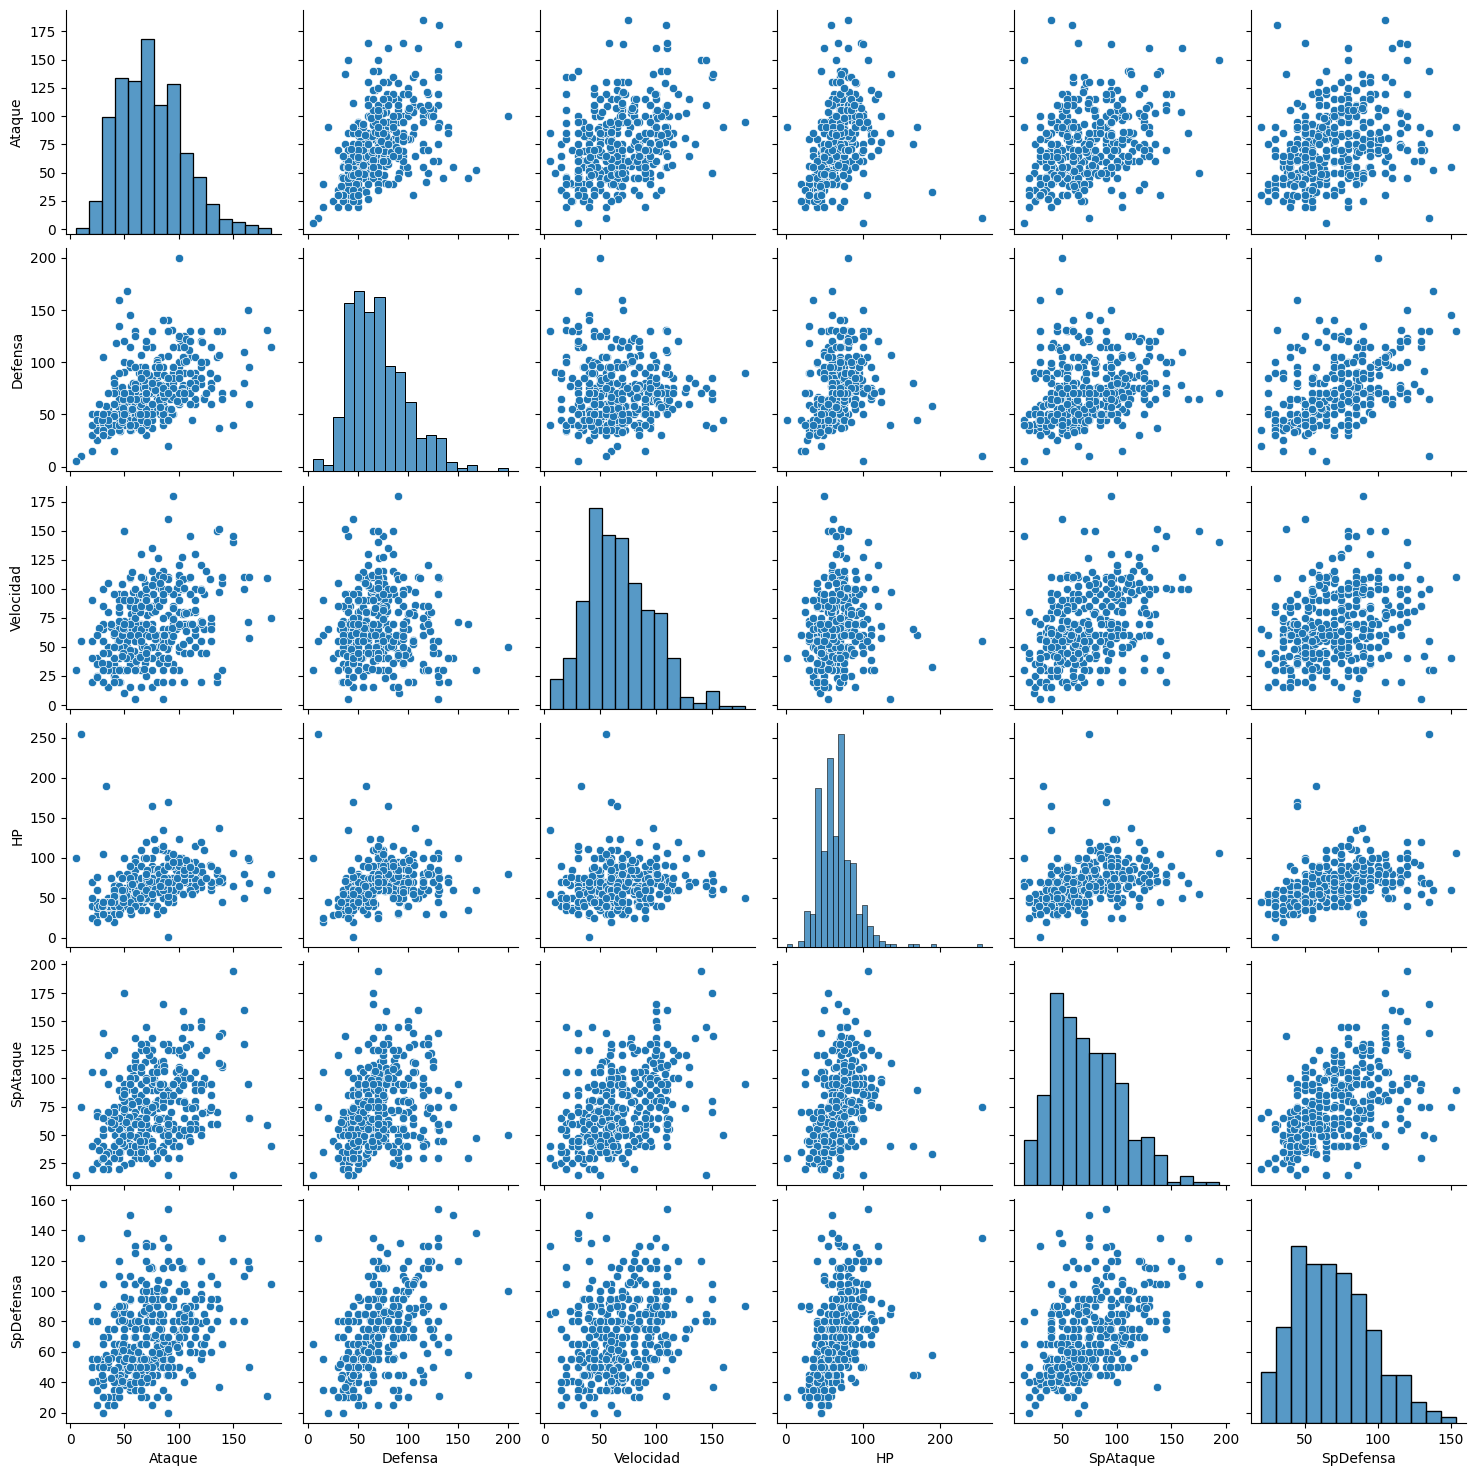

In [93]:

correlation_matrix = X_train_poke_1.corr()

# Crear el heatmap con seaborn
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix,  annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix")
plt.show()

#Pairplot
for i in range(0, len(X_train_poke_1.columns), 6):
    sns.pairplot(data=X_train_poke_1,
                x_vars=X_train_poke_1.columns[i:i+6],
                y_vars=X_train_poke_1.columns,
)  
    plt.show()

Se observa una correlacion moderadamente lineal en las variables Defensa - SpDefensa (0.53), SpDefensa - SpAtaque (0.54) y Ataque - Defensa (0.49).
No se observan correlaciones no lineales entre las variables.

In [94]:
robust_scaler = RobustScaler().set_output(transform='pandas')
X_train_poke_esc_1 = robust_scaler.fit_transform(X_train_poke_1)
X_test_poke_esc_1 = robust_scaler.transform(X_test_poke_1)
X_train_poke_esc_2 = robust_scaler.fit_transform(X_train_poke_2)
X_test_poke_esc_2 = robust_scaler.transform(X_test_poke_2)

# 4. Árboles de decisión (Clasificación)

In [123]:
def metricas_decision(y_pred_1, y_pred_2):
  f1_1 = f1_score(y_test_poke_1, y_pred_1, average='weighted')
  f1_2 = f1_score(y_test_poke_2, y_pred_2, average='weighted')

  accuracy_1 = accuracy_score(y_test_poke_1, y_pred_1)
  accuracy_2 = accuracy_score(y_test_poke_2, y_pred_2)

  precision_1 = precision_score(y_test_poke_1, y_pred_1, average='weighted', zero_division=0)
  precision_2 = precision_score(y_test_poke_2, y_pred_2, average='weighted', zero_division=0) 

  recall_1 = recall_score(y_test_poke_1, y_pred_1, average='weighted')
  recall_2 = recall_score(y_test_poke_2, y_pred_2, average='weighted')

  df_metricas = pd.DataFrame({'F1-score': [f1_1, f1_2],
                              'Accuracy': [accuracy_1, accuracy_2],
                              'Precision': [precision_1, precision_2],
                              'Recall': [recall_1, recall_2]},
                             index=['modelo_1', 'modelo_2'])
  
  # Cálculo de las matrices de confusión
  cm_1 = confusion_matrix(y_test_poke_1, y_pred_1)
  cm_2 = confusion_matrix(y_test_poke_2, y_pred_2)
  
  # Graficar las matrices de confusión
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Dos subplots uno al lado del otro
  
  sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
  axes[0].set_title('Matriz de Confusión - Modelo 1')
  axes[0].set_xlabel('Predicción')
  axes[0].set_ylabel('Real')
  sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
  axes[1].set_title('Matriz de Confusión - Modelo 2')
  axes[1].set_xlabel('Predicción')
  axes[1].set_ylabel('Real')
  plt.tight_layout()
  plt.show()
  
  return df_metricas

In [139]:
arbol_clasificacion_1 = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=3, random_state=42,class_weight='balanced',splitter='best')
arbol_clasificacion_1.fit(X_train_poke_esc_1,y_train_poke_1)
arbol_clasificacion_2 = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=3, random_state=42,class_weight='balanced',splitter='best')
arbol_clasificacion_2.fit(X_train_poke_esc_2,y_train_poke_2)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=3,
                       min_samples_split=3, random_state=42)

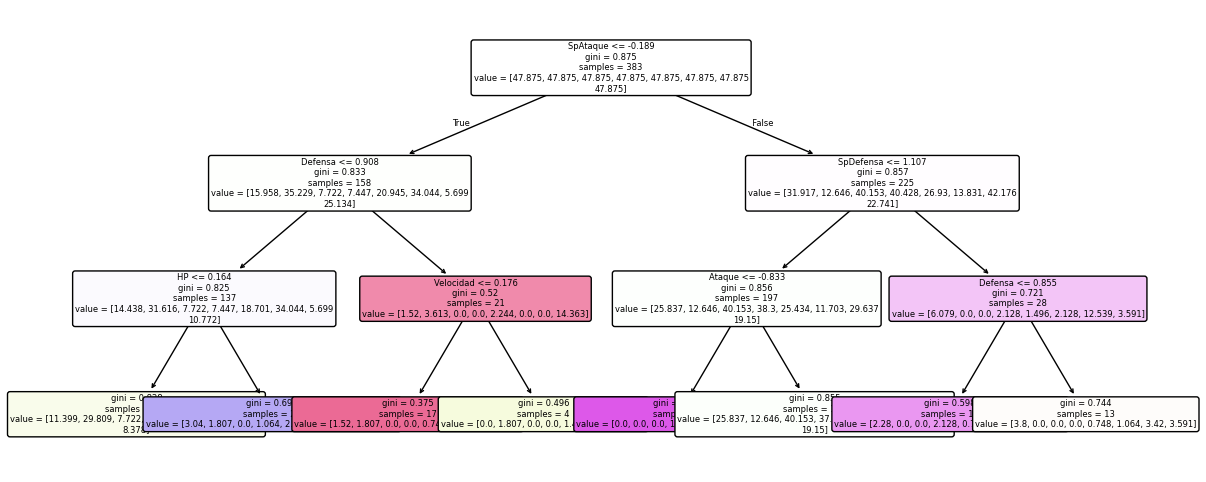

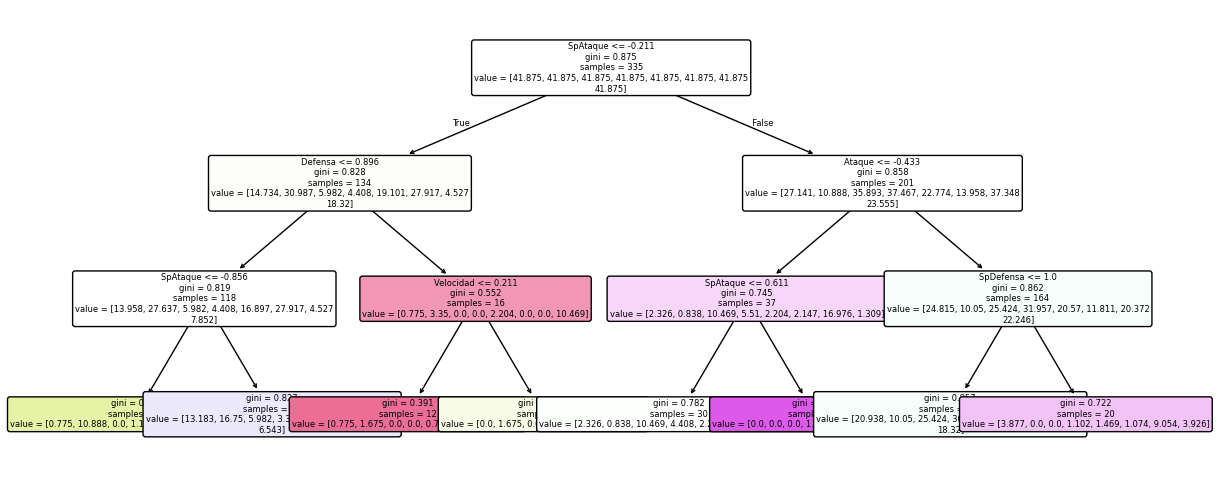

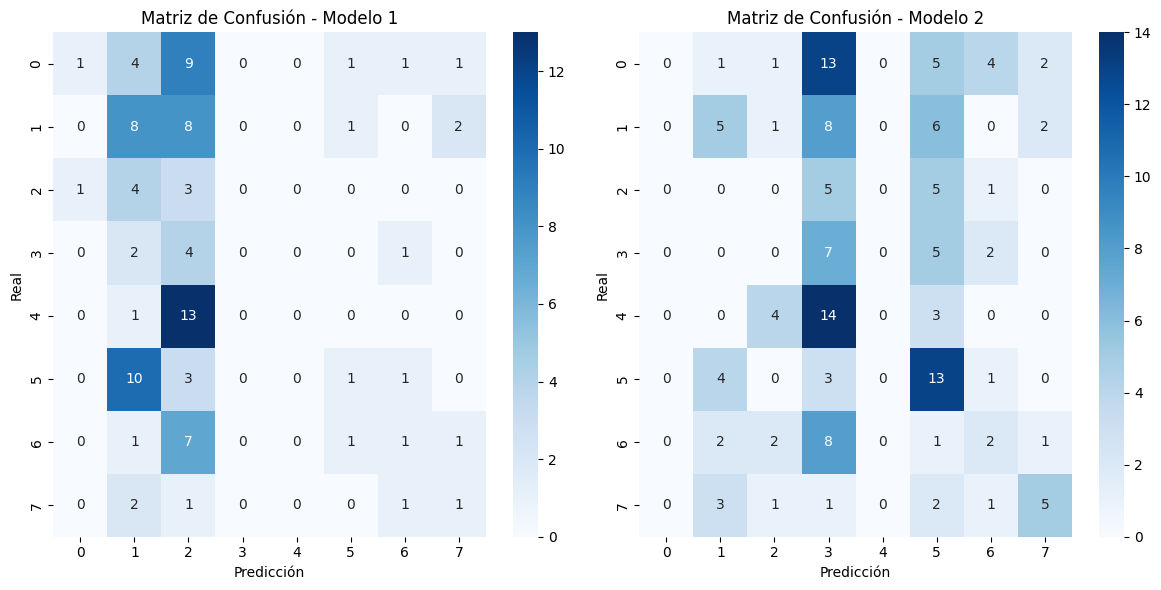

,F1-score,Accuracy,Precision,Recall
modelo_1,0.130847,0.156250,0.215625,0.156250
modelo_2,0.177807,0.222222,0.175198,0.222222


In [140]:
features = list(X_train_poke_esc_1.columns)
plt.figure(figsize=(14,6))
tree.plot_tree(arbol_clasificacion_1, feature_names=features, fontsize=6, filled=True, rounded=True)
plt.show()

plt.figure(figsize=(14,6))
tree.plot_tree(arbol_clasificacion_2, feature_names=features, fontsize=6, filled=True, rounded=True)
plt.show()

metricas_decision(arbol_clasificacion_1.predict(X_test_poke_esc_1),arbol_clasificacion_2.predict(X_test_poke_esc_2))

Se observa como a medida que aumenta la profundidad el gini disminuye lo que significa que los nodos se van volviendo mas puros. El modelo calaramente necesita mejores ajustes en los hiperparametros.

Tambien se observa que si aplicamos balanceo de clases con 'class_weight='balanced'' se obtienen mejores .

In [138]:
#Optimizamos los hiperparametros
param_grid = {
    'max_depth': list(range(3,15)),
    'min_samples_leaf': list(range(1,20)),
    'min_samples_split': list(range(2,20))
}

# Crear el GridSearchCV
grid_search = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=42,class_weight='balanced',splitter='best'), param_grid=param_grid,cv=4)

# Ajustar el modelo
grid_search.fit(X_train_poke_esc_1, y_train_poke_1)

# Mostrar los mejores hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3}


c:\Users\Usuario\OneDrive\Escritorio\Facultad\data mining\TP2\TP2_mineria\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [152]:
arbol_clasificacion_ajustado_1 = tree.DecisionTreeClassifier(max_depth=9, min_samples_leaf=1, min_samples_split=3, random_state=42,class_weight='balanced',splitter='best')
arbol_clasificacion_ajustado_1.fit(X_train_poke_esc_1,y_train_poke_1)
arbol_clasificacion_ajustado_2 = tree.DecisionTreeClassifier(max_depth=9, min_samples_leaf=1, min_samples_split=3, random_state=42,class_weight='balanced',splitter='best')
arbol_clasificacion_ajustado_2.fit(X_train_poke_esc_2,y_train_poke_2)

DecisionTreeClassifier(class_weight='balanced', max_depth=9,
                       min_samples_split=3, random_state=42)

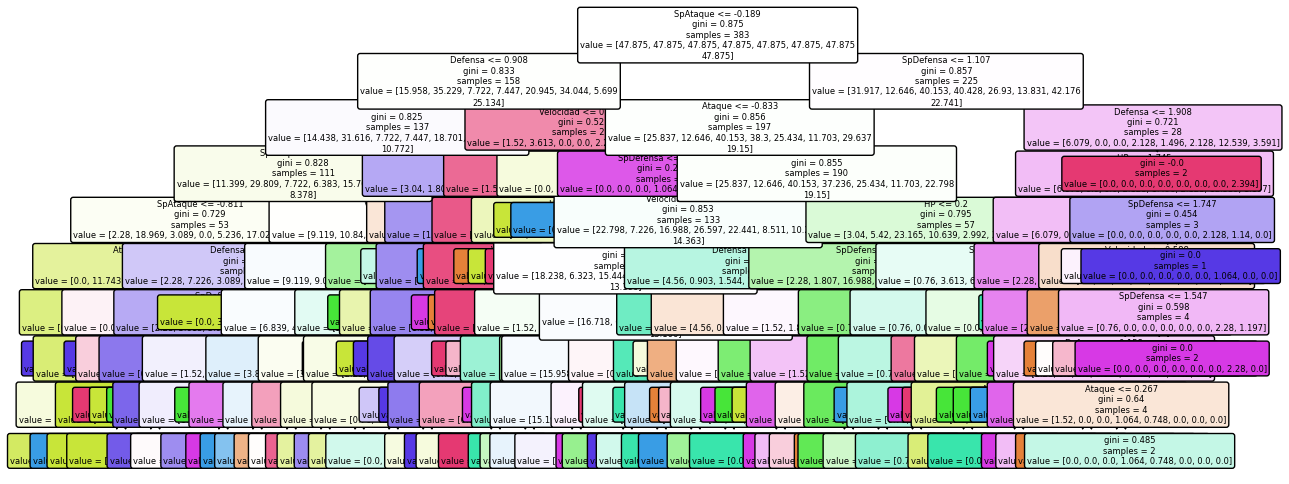

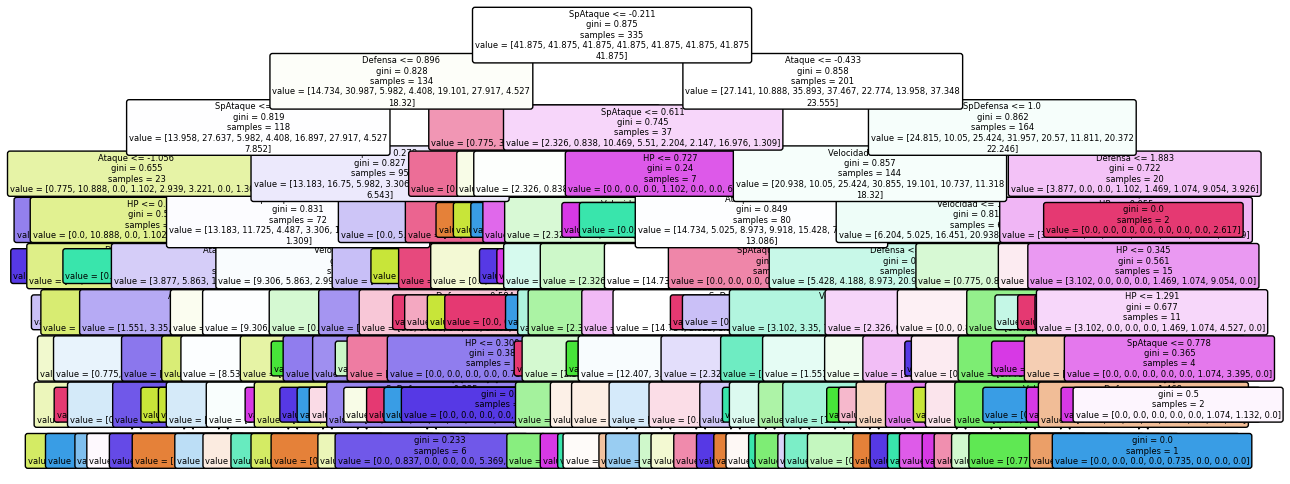

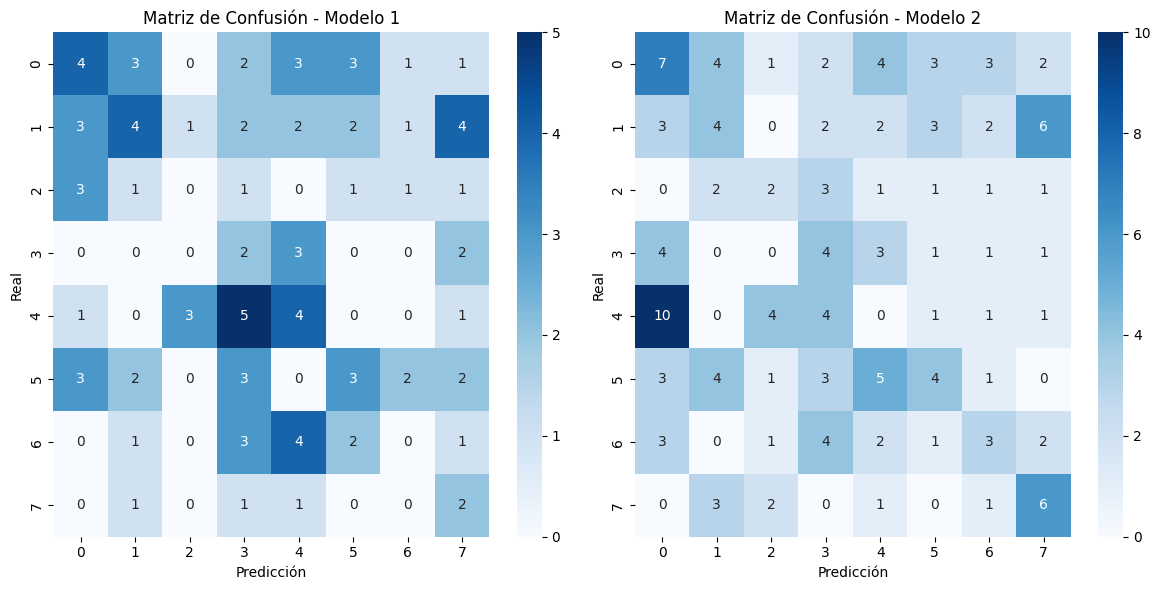

,F1-score,Accuracy,Precision,Recall
modelo_1,0.192649,0.197917,0.208611,0.197917
modelo_2,0.202148,0.208333,0.205459,0.208333


In [153]:
features = list(X_train_poke_esc_1.columns)
plt.figure(figsize=(14,6))
tree.plot_tree(arbol_clasificacion_ajustado_1, feature_names=features, fontsize=6, filled=True, rounded=True)
plt.show()

plt.figure(figsize=(14,6))
tree.plot_tree(arbol_clasificacion_ajustado_2, feature_names=features, fontsize=6, filled=True, rounded=True)
plt.show()

metricas_decision(arbol_clasificacion_ajustado_1.predict(X_test_poke_esc_1),arbol_clasificacion_ajustado_2.predict(X_test_poke_esc_2))

Se observa que el modelo se sobreajusto a los datos de entrenamiento ya que tiene una capacidad muy baja para predecir correctamento los datos de testeo. Se va a probar limitar la profundidad maxima, asi el modelo puede lograr una mejor generalización.

In [157]:
#Optimizamos los hiperparametros
param_grid = {
    'max_depth': list(range(1,6)),
    'min_samples_leaf': list(range(1,4)),
    'min_samples_split': list(range(2,5))
}

# Crear el GridSearchCV
grid_search = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=42,class_weight='balanced',splitter='best'), param_grid=param_grid,cv=4)

# Ajustar el modelo
grid_search.fit(X_train_poke_esc_1, y_train_poke_1)

# Mostrar los mejores hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [173]:
arbol_clasificacion_ajustado_1 = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=2, random_state=42,class_weight='balanced',splitter='best')
arbol_clasificacion_ajustado_1.fit(X_train_poke_esc_1,y_train_poke_1)
arbol_clasificacion_ajustado_2 = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=2, random_state=42,class_weight='balanced',splitter='best')
arbol_clasificacion_ajustado_2.fit(X_train_poke_esc_2,y_train_poke_2)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       random_state=42)

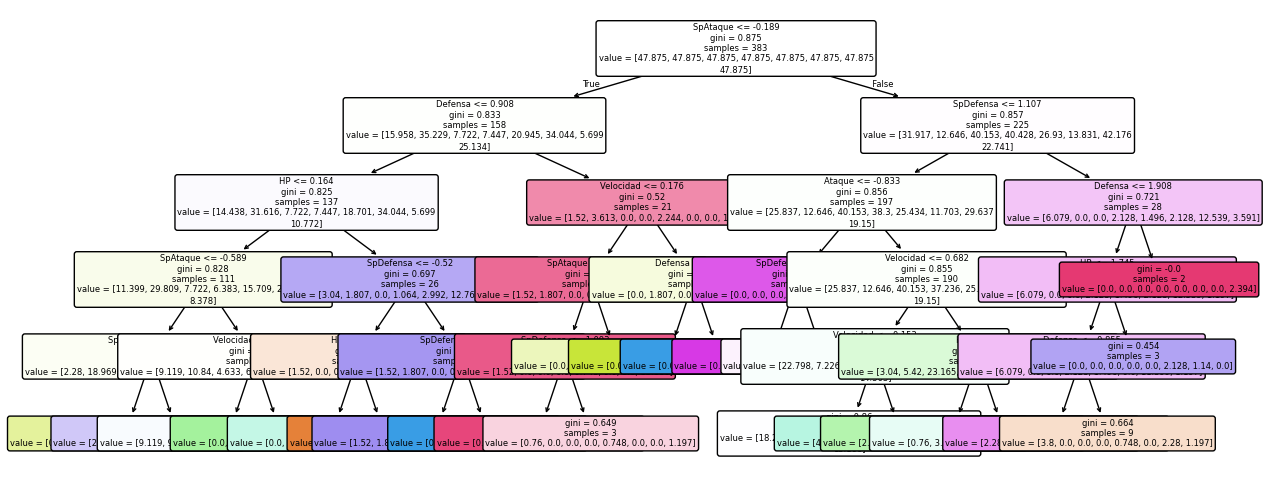

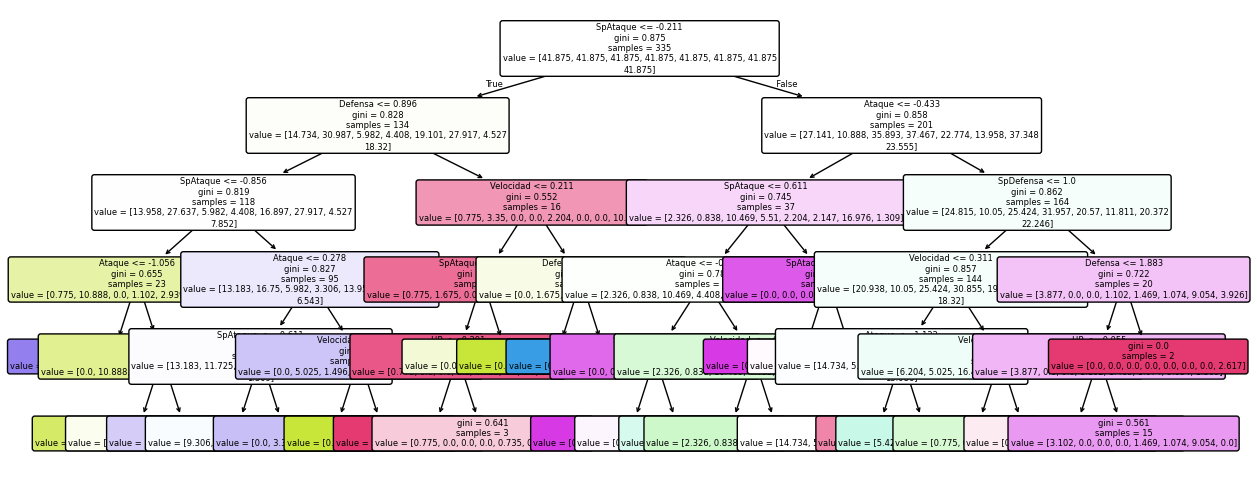

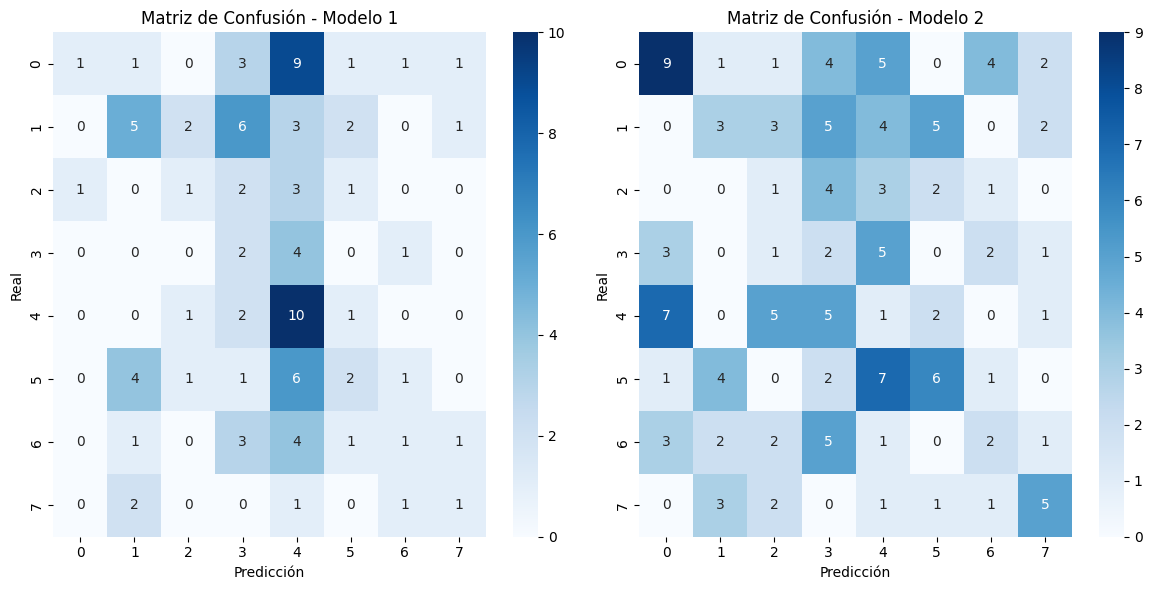

,F1-score,Accuracy,Precision,Recall
modelo_1,0.211611,0.239583,0.300464,0.239583
modelo_2,0.213824,0.201389,0.236109,0.201389


In [174]:
features = list(X_train_poke_esc_1.columns)
plt.figure(figsize=(14,6))
tree.plot_tree(arbol_clasificacion_ajustado_1, feature_names=features, fontsize=6, filled=True, rounded=True)
plt.show()

plt.figure(figsize=(14,6))
tree.plot_tree(arbol_clasificacion_ajustado_2, feature_names=features, fontsize=6, filled=True, rounded=True)
plt.show()

metricas_decision(arbol_clasificacion_ajustado_1.predict(X_test_poke_esc_1),arbol_clasificacion_ajustado_2.predict(X_test_poke_esc_2))

Se observa que si se limita la profundidad maxima el modelo pierde la capacidad de predecir algunas variables. No se notaron mejoras en el modelo al limitar la profundiad maxima.

## Concluciones árboles de clasificación

Se puede concluir que si la profundidad maxima es muy alta el modelo tiende a sobreajustar, y si se limita mucho la profundidad maxima el modelo tiende a sub-ajustar el modelo. Si el número mínimo de observaciones es bajo el modelo va a tender a producir nodos con pocas observaciones lo que lleva al modelo a memorizar las respuestas (sobreajuste) mientras que si el número mínimo de observaciones es muy alto el modelo pierde la capacidad de generalizar (underfitting). Si el número mínimo de observaciones por separación es alto el modelo se vuelve menos complejo ya que limita la cantidad de separaciones, lo que es bueno si se quiere evitar el sobreajuste pero tambien puede perder su capacidad de generalizacion.